Checkpoints sugeridos:

1) Coleta de dados via web scrapping. Bibliotecas como Selenium e BeautifulSoup podem ajudar. <br>
<br>
2) Análise exploratória: Gráficos de dispersão entre nota padronizada dos dois rankings. São correlacionados? Existem outliers?<br>
<br>
3) Modelo explicativo: Regressão linear múltipla entre os 4 itens do ranking do Legisla Brasil e a nota do Ranking dos Políticos, por exemplo. Os 4 itens do Legisla explicam qual variabilidade do Ranking dos Políticos?<br>
<br>
4) Discussão: Por que são diferentes? Por que são iguais? Existem viéses políticos? São apartidários? Qual sua opinião que justifique os resultados?

### Tratamento dos dados dos dois sites

In [1]:
import pandas as pd
import numpy as np
import re
from unidecode import unidecode #retirar acentos
import requests 
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
#leitura dos dados
df_site1 = pd.read_csv('rank_legislabr_completo.csv') 
df_site2 = pd.read_csv('df_site2.csv')
df_merge = pd.read_csv('df_merge.csv')

In [3]:
#tratamento inicial dos dataframes
del df_site1['Unnamed: 0']

In [12]:
# criando novo dataframe sem valores não comuns entre as tabelas
df_3 = pd.merge(df_site1, df_site2)
df_3 = df_3.rename(columns={'nota': 'nota_site2'})

Foi verificado que alguns (78) deputados não estão presentes na lista dos dois sites, <br>
sendo assim foi optado por removê-los da análise.

In [49]:
#df_3

In [14]:
# criando coluna com o valor da média ponderada entre as notas do primeiro site
df_3.insert(7, 'avg_site1', (df_3['n_prod_leg']*8 + df_3['n_fisc']*5 + df_3['n_mobi']*3 + df_3['n_alin_partd']*1)/17)

In [50]:
df_3.head()

,nome,estado,partido,ideologia,n_prod_leg,n_fisc,n_mobi,n_alin_partd,avg_site1,nota_site2
0,abou anni,São Paulo,UNIÃO,direita,3.8,0.9,2.4,6.4,2.852941,6.55
1,acacio favacho,Amapá,MDB,centro,2.6,0.2,2.1,6.4,2.029412,6.12
2,adolfo viana,Bahia,PSDB,centro,2.8,0.9,2.4,5.5,2.329412,6.82
3,adriana ventura,São Paulo,NOVO,direita,6.4,2.9,7.3,10.0,5.741176,8.24
4,adriano do baldy,Goiás,PP,direita,2.3,0.0,2.1,10.0,2.041176,6.82


Através da análise bivariada entre a média do site 1 (https://indice.legislabrasil.org/public/) e o site 2 (https://www.politicos.org.br/) há indicios que mostram uma correlação negativa entre eles. Ou seja, deputados que tem nota alta no site 1 tendem a ter nota baixa no site 2 e vice-versa.

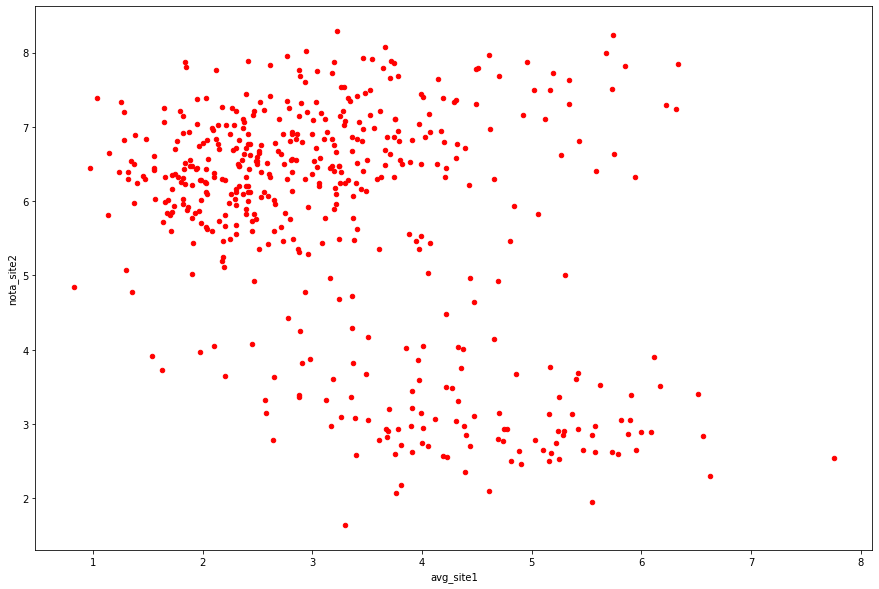

In [19]:
ax1 = df_3.plot(kind='scatter', x='avg_site1', y='nota_site2', color='r')    
#ax2 = df_3.plot(kind='scatter', x='n_fisc', y='nota_site2', color='g', ax=ax1)    
#ax3 = df_3.plot(kind='scatter', x='n_mobi', y='nota_site2', color='b', ax=ax1)
#ax4 = df_3.plot(kind='scatter', x='n_alin_partd', y='nota_site2', color='black', ax=ax1)
plt.rcParams['figure.figsize'] = (15,10)
#plt.figure(figsize=(10, 10)) 
plt.show()

Um quesito chamou a atenção nessa análise. Detectou-se uma certa subjetividade adota pelo site 2 quando propõe notas baseada no direcionamento de um conselho do próprio. Algumas notas são compostas de acordo com "o posicionamento dos parlamentares nas principais votações do Congresso". Segundo o site "O aproveitamento de acerto nos votos reflete a nota do político neste critério". Apesar do Conselho ser composto por 32 pessoas não é exposto como ele é formado, qual a diversidade do corpo, se é representativo com a população interessada, no caso a população brasileira. Deixando parecer que o certo ou errado na votação do candidato pode representar uma nota enviesada. 
<br>
<br>
Com isso surgiu a curiosidade de verificar a nota por ideologia do partido dos deputados. Em resumo, classificando o partido em Esquerda, Centro e Direita.
<br>


### Criando nova coluna para classificação ideólogica dos partidos. <br>
Para tal, foi utilizida classificação dada pelo jornal Folha na seguinte matéria:
https://www1.folha.uol.com.br/poder/2022/09/o-que-faz-um-partido-ser-de-direita-ou-esquerda-folha-cria-metrica-que-posiciona-legendas.shtml
    
Esse ranking levou em consideração o comportamento do partido de acordo com 7 quesitos: 
Votação dos deputados na legenda da câmara; coligações; autodeclaração dos congressistas; 
frente parlamentares, opinião de especialistas, migração partidária e o 
posicionamento no GPS Ideológico da Folha (baseado em seguidores do Twitter, atualizado em 2022).
A classificação ficou a seguinte: <br>
<br>
Esquerda: PCO, PSTU, PSOL, UP, PT, PCB, REDE, PCdoB, PSB, PV e PDT<br>
<br>
Centro: Solidariedade, Cidadania, Avante, PSD, PROS, MDB, Agir, PSDB, Podemos e PMN<br>
<br>
Direita: Rebuplicanos, DC, PRTB, PMB, PP, PTB, União, Patriota, PSC, PL e Novo<br>
<br>
<br>
As listas foram reduzidas a somente partidos contidos nos dataset gerados pelo webscraping.

In [25]:
esquerda = ['PSOL', 'PT', 'REDE', 'PCdoB', 'PSB', 'PV', 'PDT']
centro = ['SOLIDARIEDADE', 'CIDADANIA', 'AVANTE', 'PSD', 'PROS', 'MDB', 'PSDB', 'PODE']
direita = ['REPUBLICANOS', 'PP', 'PTB', 'UNIÃO', 'PATRIOTA', 'PSC', 'PL', 'NOVO']

b = list(df_3['partido'])
ideologia = []
for x in b:
    if x in esquerda:
        #print('esquerda')
        ideologia.append('esquerda')
    elif x in direita:
        #print('direita')
        ideologia.append('direita')
    else:
        ideologia.append('centro')

df_3.insert(3, 'ideologia', ideologia)

Graficamente também fica visível a suposição anteriormente feita

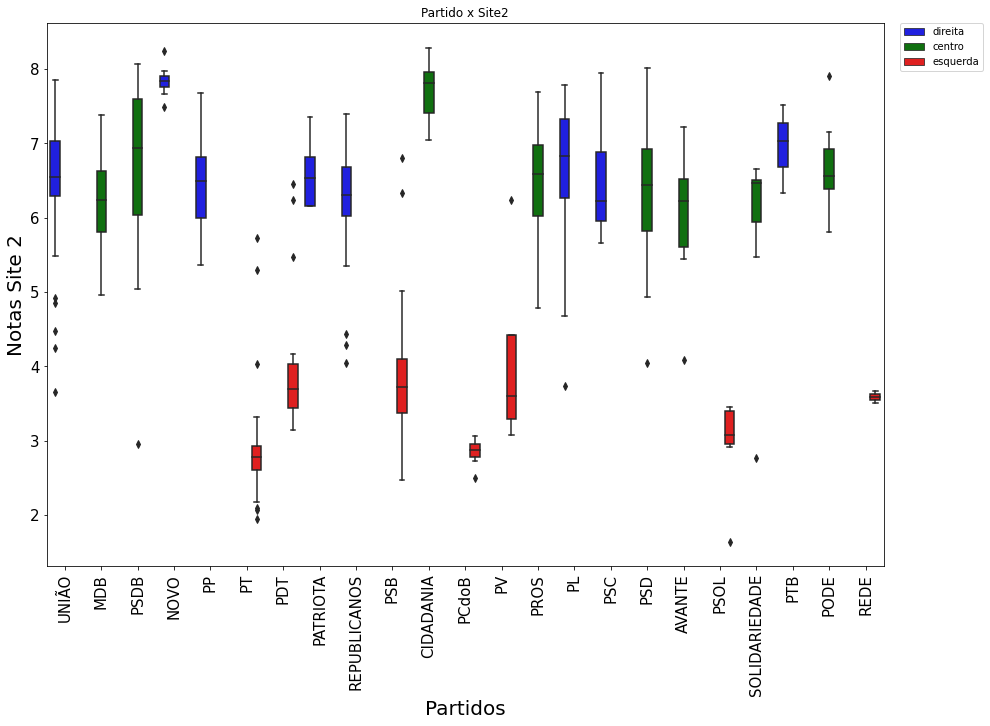

In [42]:
#boxplot
plt.title('Partido x Site2')
graph_boxp = sns.boxplot(data=df_3, x='partido', y='nota_site2', hue = df_3['ideologia'], palette=["blue", "green", "red"])
graph_boxp.set_xlabel("Partidos",fontsize=20)
graph_boxp.set_ylabel("Notas Site 2",fontsize=20)
plt.xticks(rotation=90, size=15)
plt.yticks(size=15)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.rcParams['figure.figsize'] = (15,10)
plt.show()

Comparando a média por ideologia também é constatado que Centro e Direita tem notas similares e opostas a Esquerda. No site 1 o primeiro grupo tem notas mais baixas que o segundo grupo, acontecendo o inverso no site 2.

In [48]:
#df_3.groupby(['partido']).mean().sort_values(['nota_site2'])
site1_vs_site2 = df_3.groupby(['ideologia']).mean()
site1_vs_site2.drop(['n_prod_leg', 'n_fisc', 'n_mobi', 'n_alin_partd'], axis=1, inplace=True)
site1_vs_site2

,avg_site1,nota_site2
ideologia,,
centro,2.750615,6.406418
direita,2.971302,6.540544
esquerda,4.370895,3.322435
